In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jinja2
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [17]:
df = pd.read_csv('concrete_data.csv')
df.shape

(1030, 9)

In [18]:
df.isnull().values.any()

False

In [19]:
df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [20]:
df1 = df.copy(deep=True)

array([[<AxesSubplot: title={'center': 'Cement'}>,
        <AxesSubplot: title={'center': 'Blast Furnace Slag'}>,
        <AxesSubplot: title={'center': 'Fly Ash'}>],
       [<AxesSubplot: title={'center': 'Water'}>,
        <AxesSubplot: title={'center': 'Superplasticizer'}>,
        <AxesSubplot: title={'center': 'Coarse Aggregate'}>],
       [<AxesSubplot: title={'center': 'Fine Aggregate'}>,
        <AxesSubplot: title={'center': 'Age'}>,
        <AxesSubplot: title={'center': 'Strength'}>]], dtype=object)

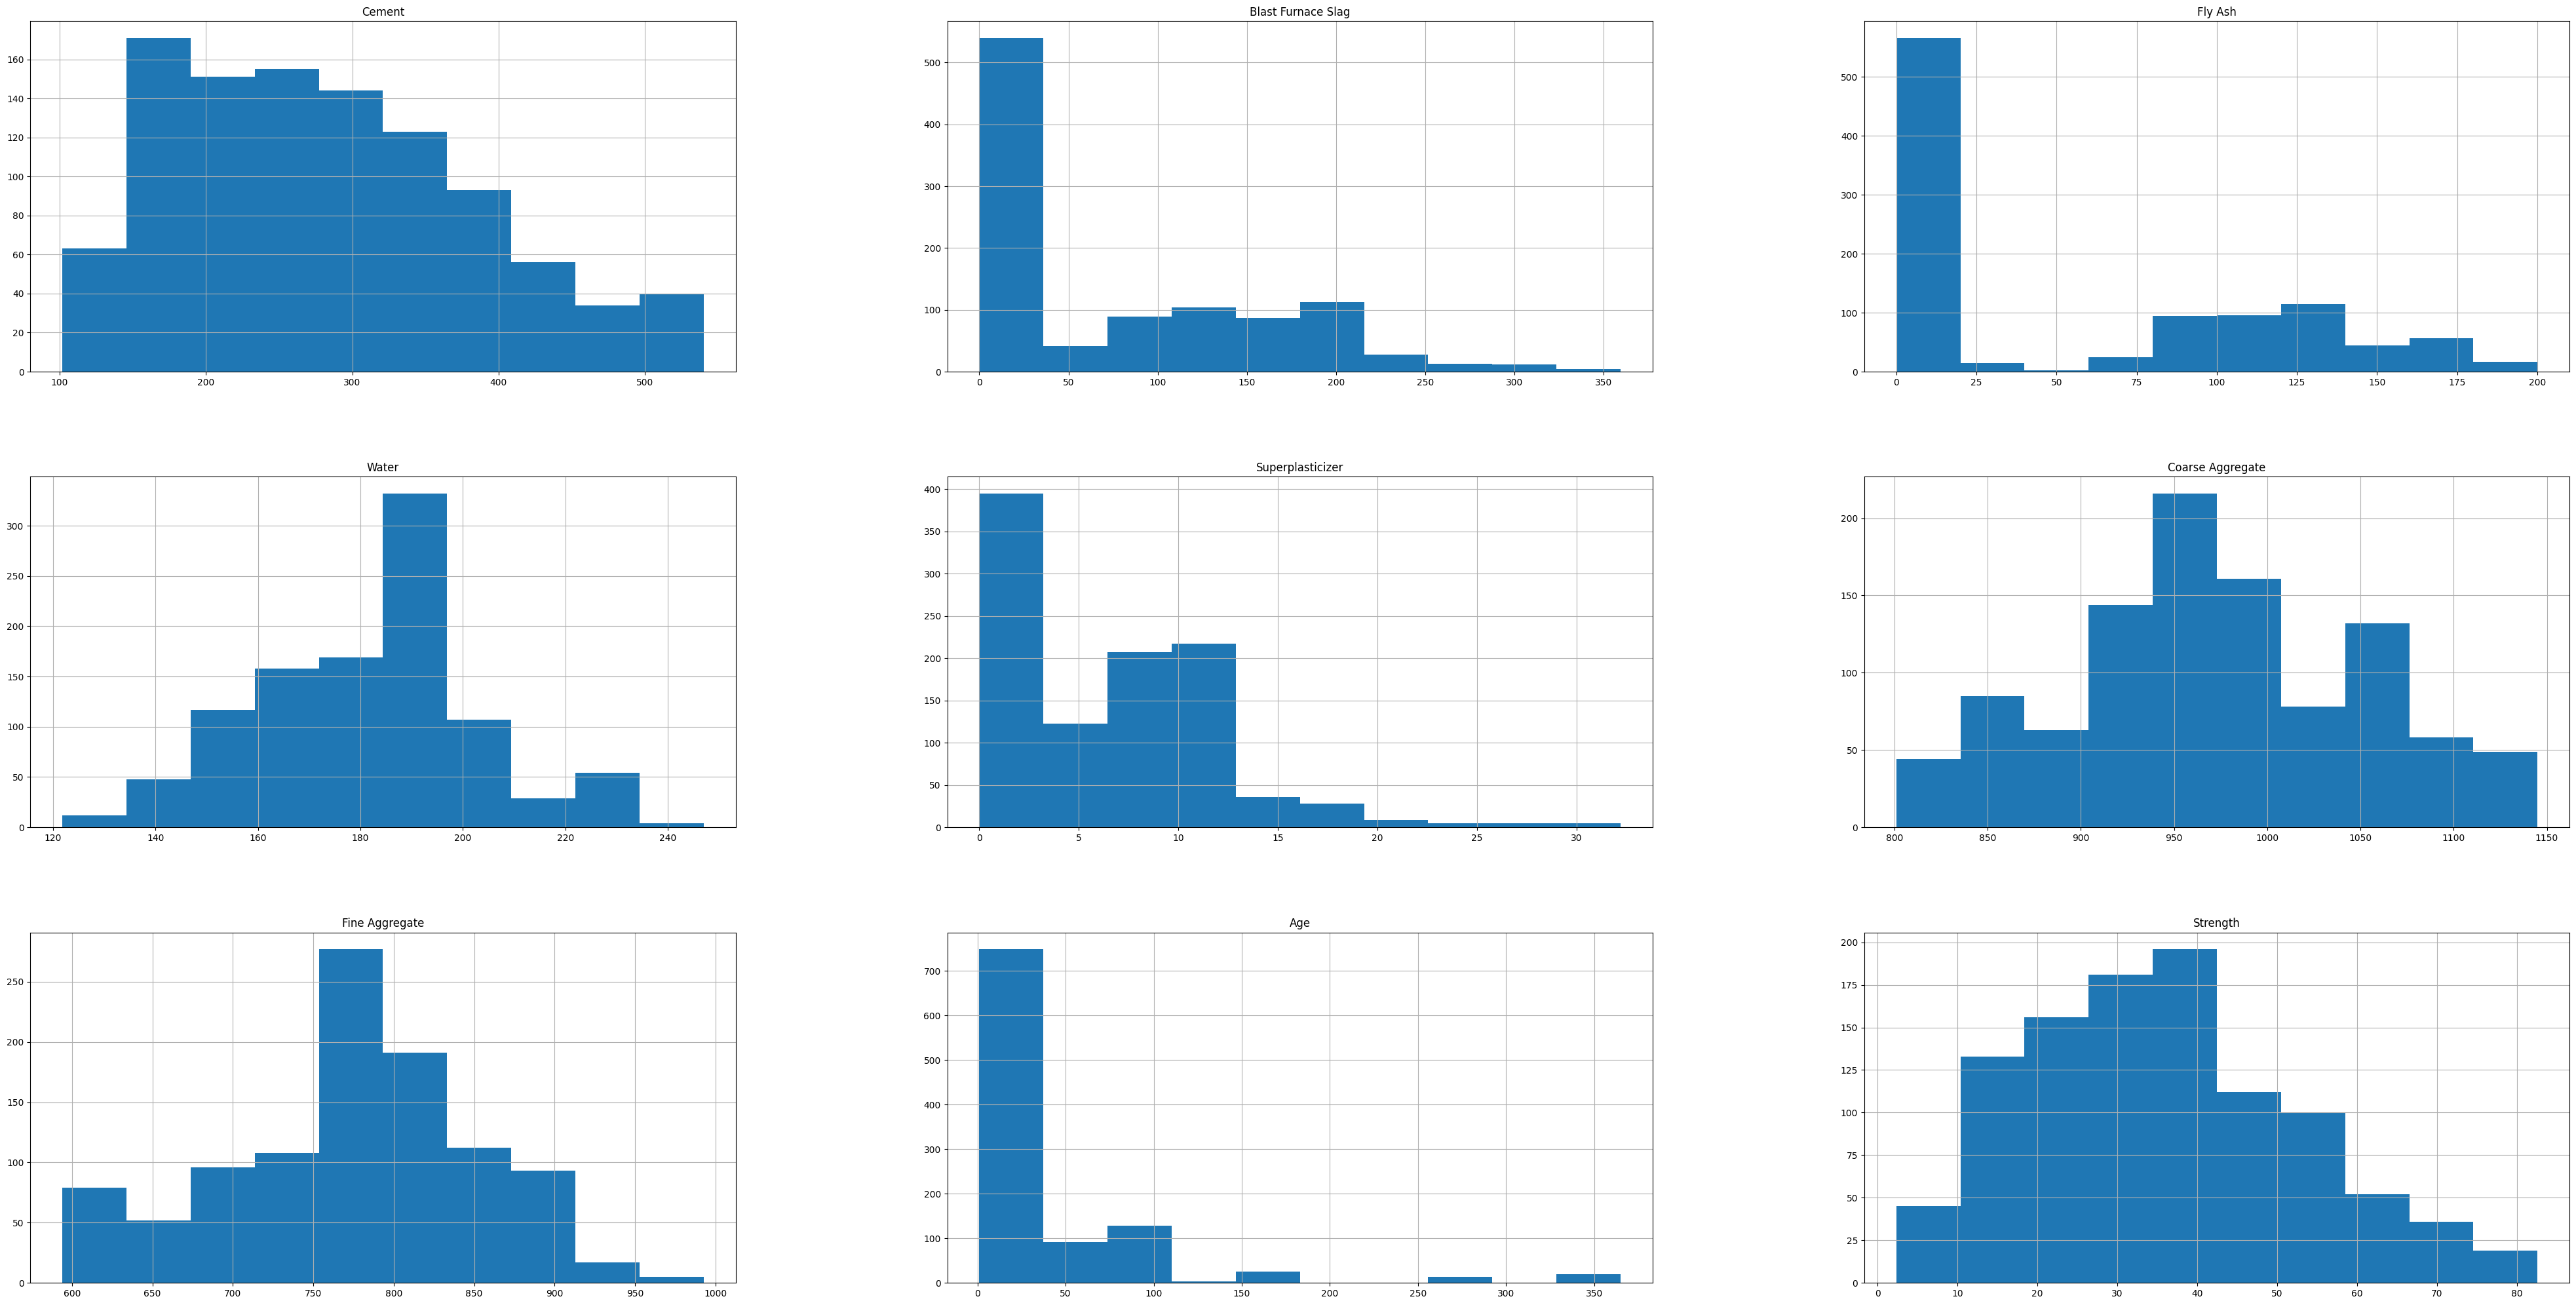

In [21]:
df1.hist(figsize=(50,25))

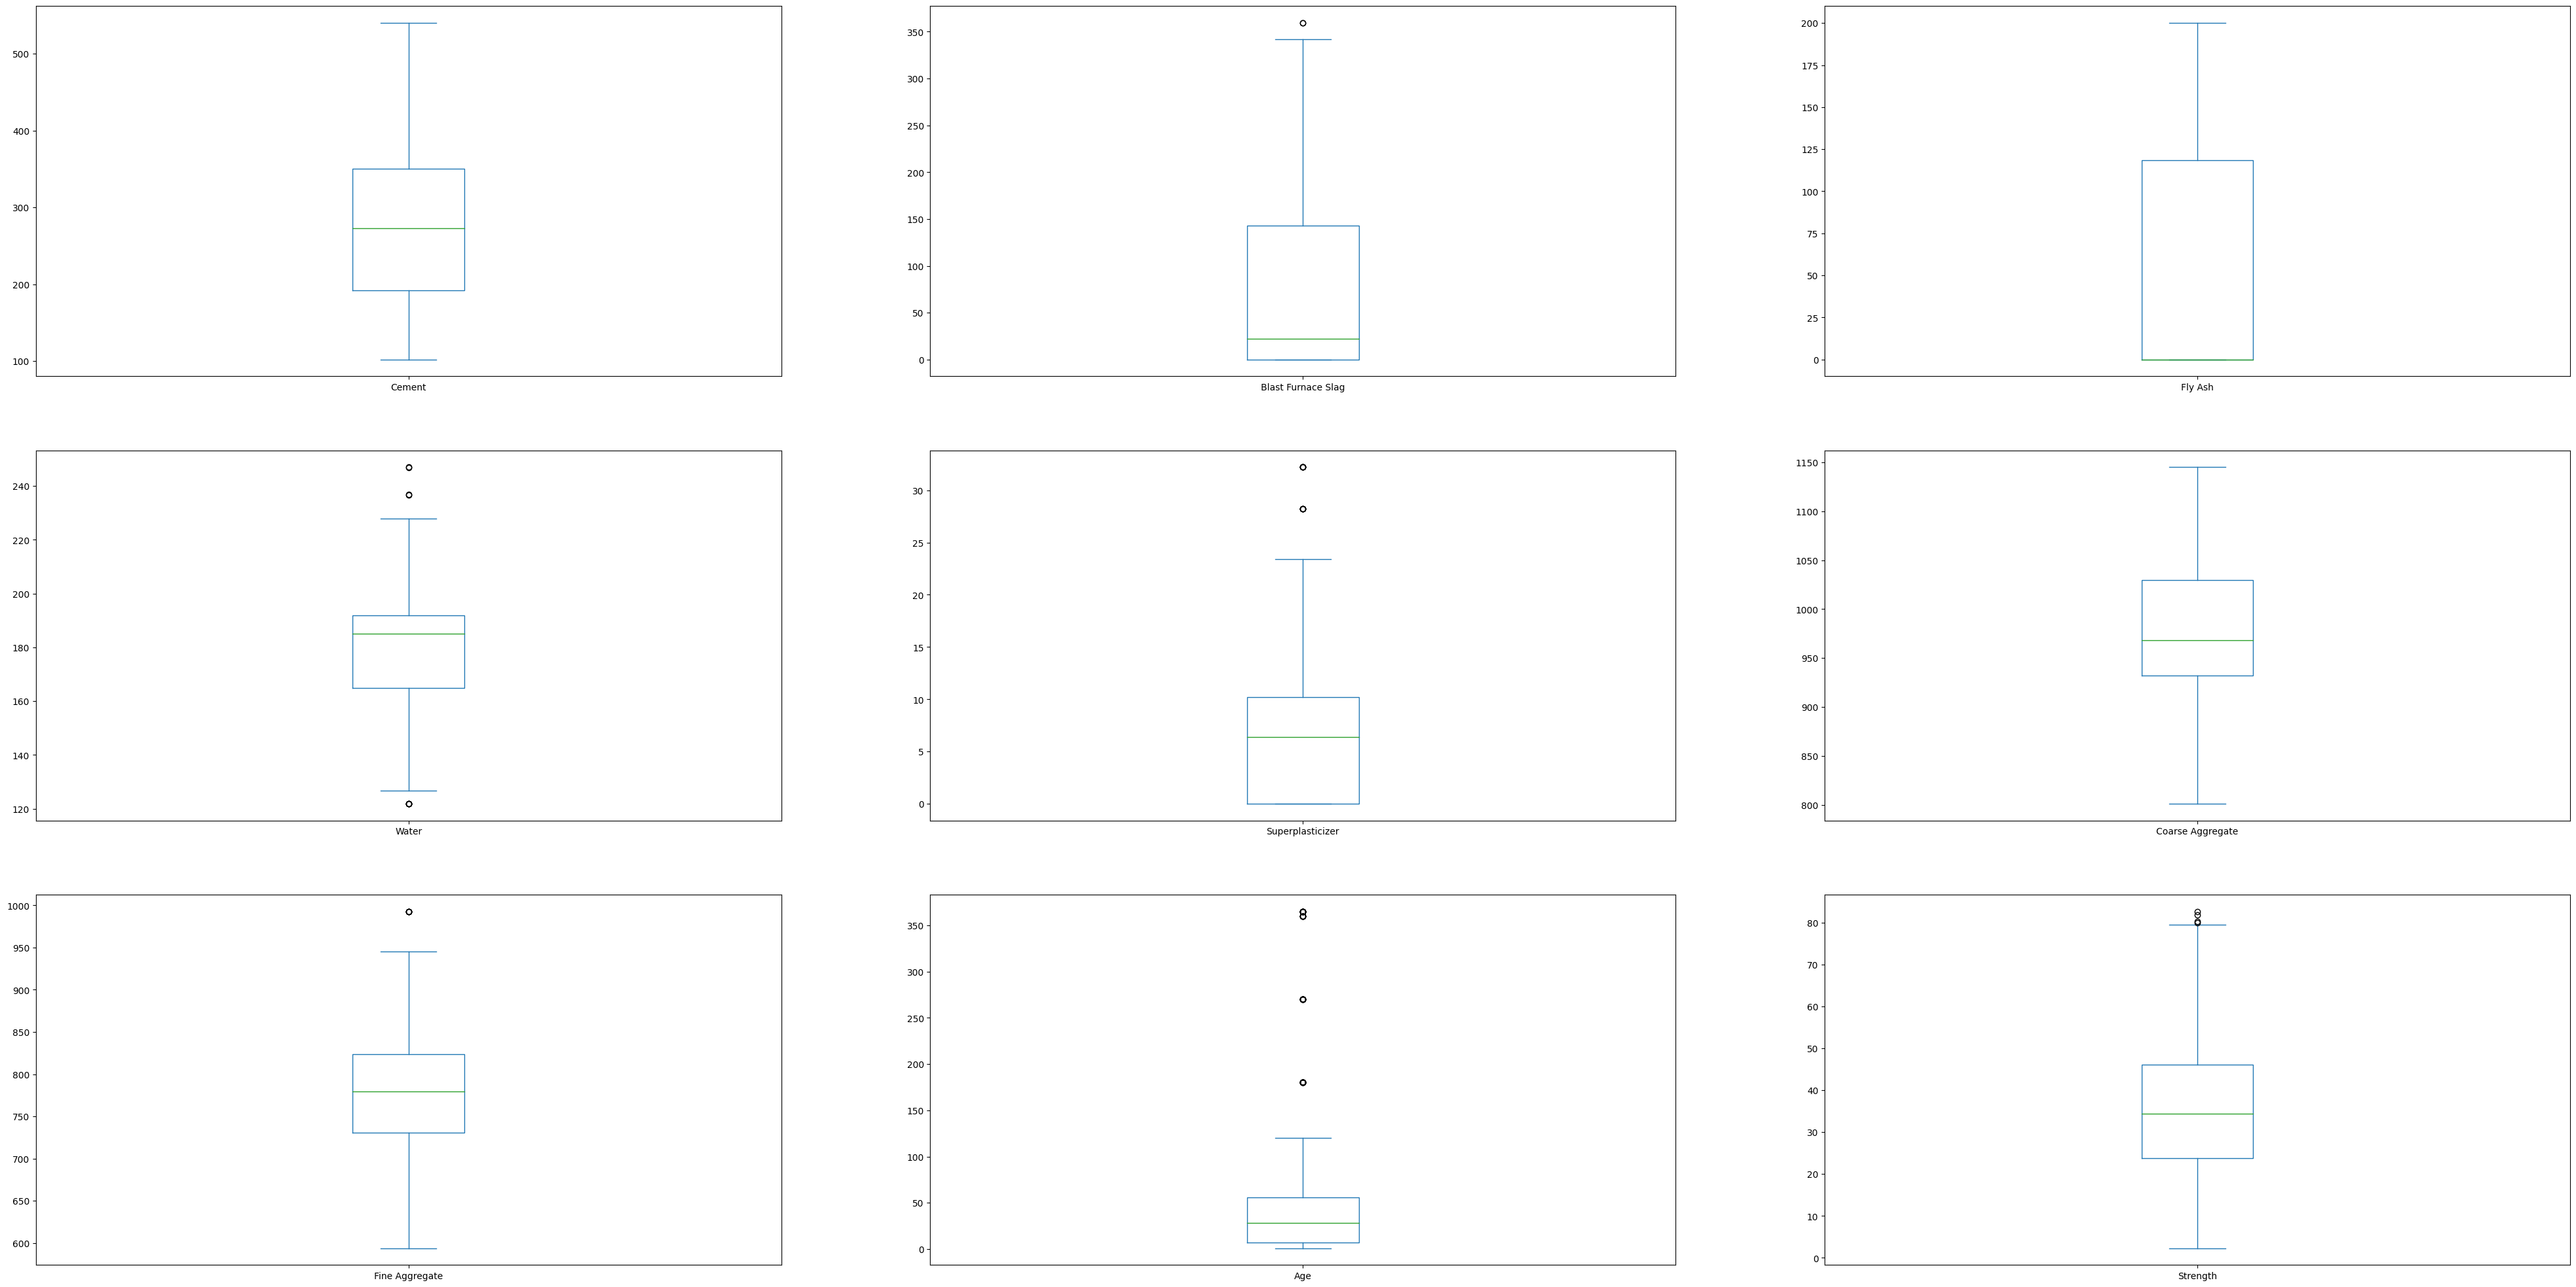

In [22]:
df1.plot(kind = "box",subplots = True,layout = (3,3),figsize=(50,25)) #Boxplot to check the outliers
plt.show()

In [23]:
#Using the InterQuartile Range to fill the values
def remove_outlier(i , col):
    Q1 = i[col].quantile(0.25)
    Q3 = i[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1-1.5*IQR
    upper_whisker = Q3+1.5*IQR
    df1[col] = np.clip(i[col] , lower_whisker , upper_whisker)
    return i

def treat_outliers_all(df , col_list):
    for c in col_list:
        i = remove_outlier(df , c)
    return i

In [24]:
df1.columns

Index(['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age', 'Strength'],
      dtype='object')

In [25]:
rem_list = ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age']

In [26]:
df2=treat_outliers_all(df1,rem_list)

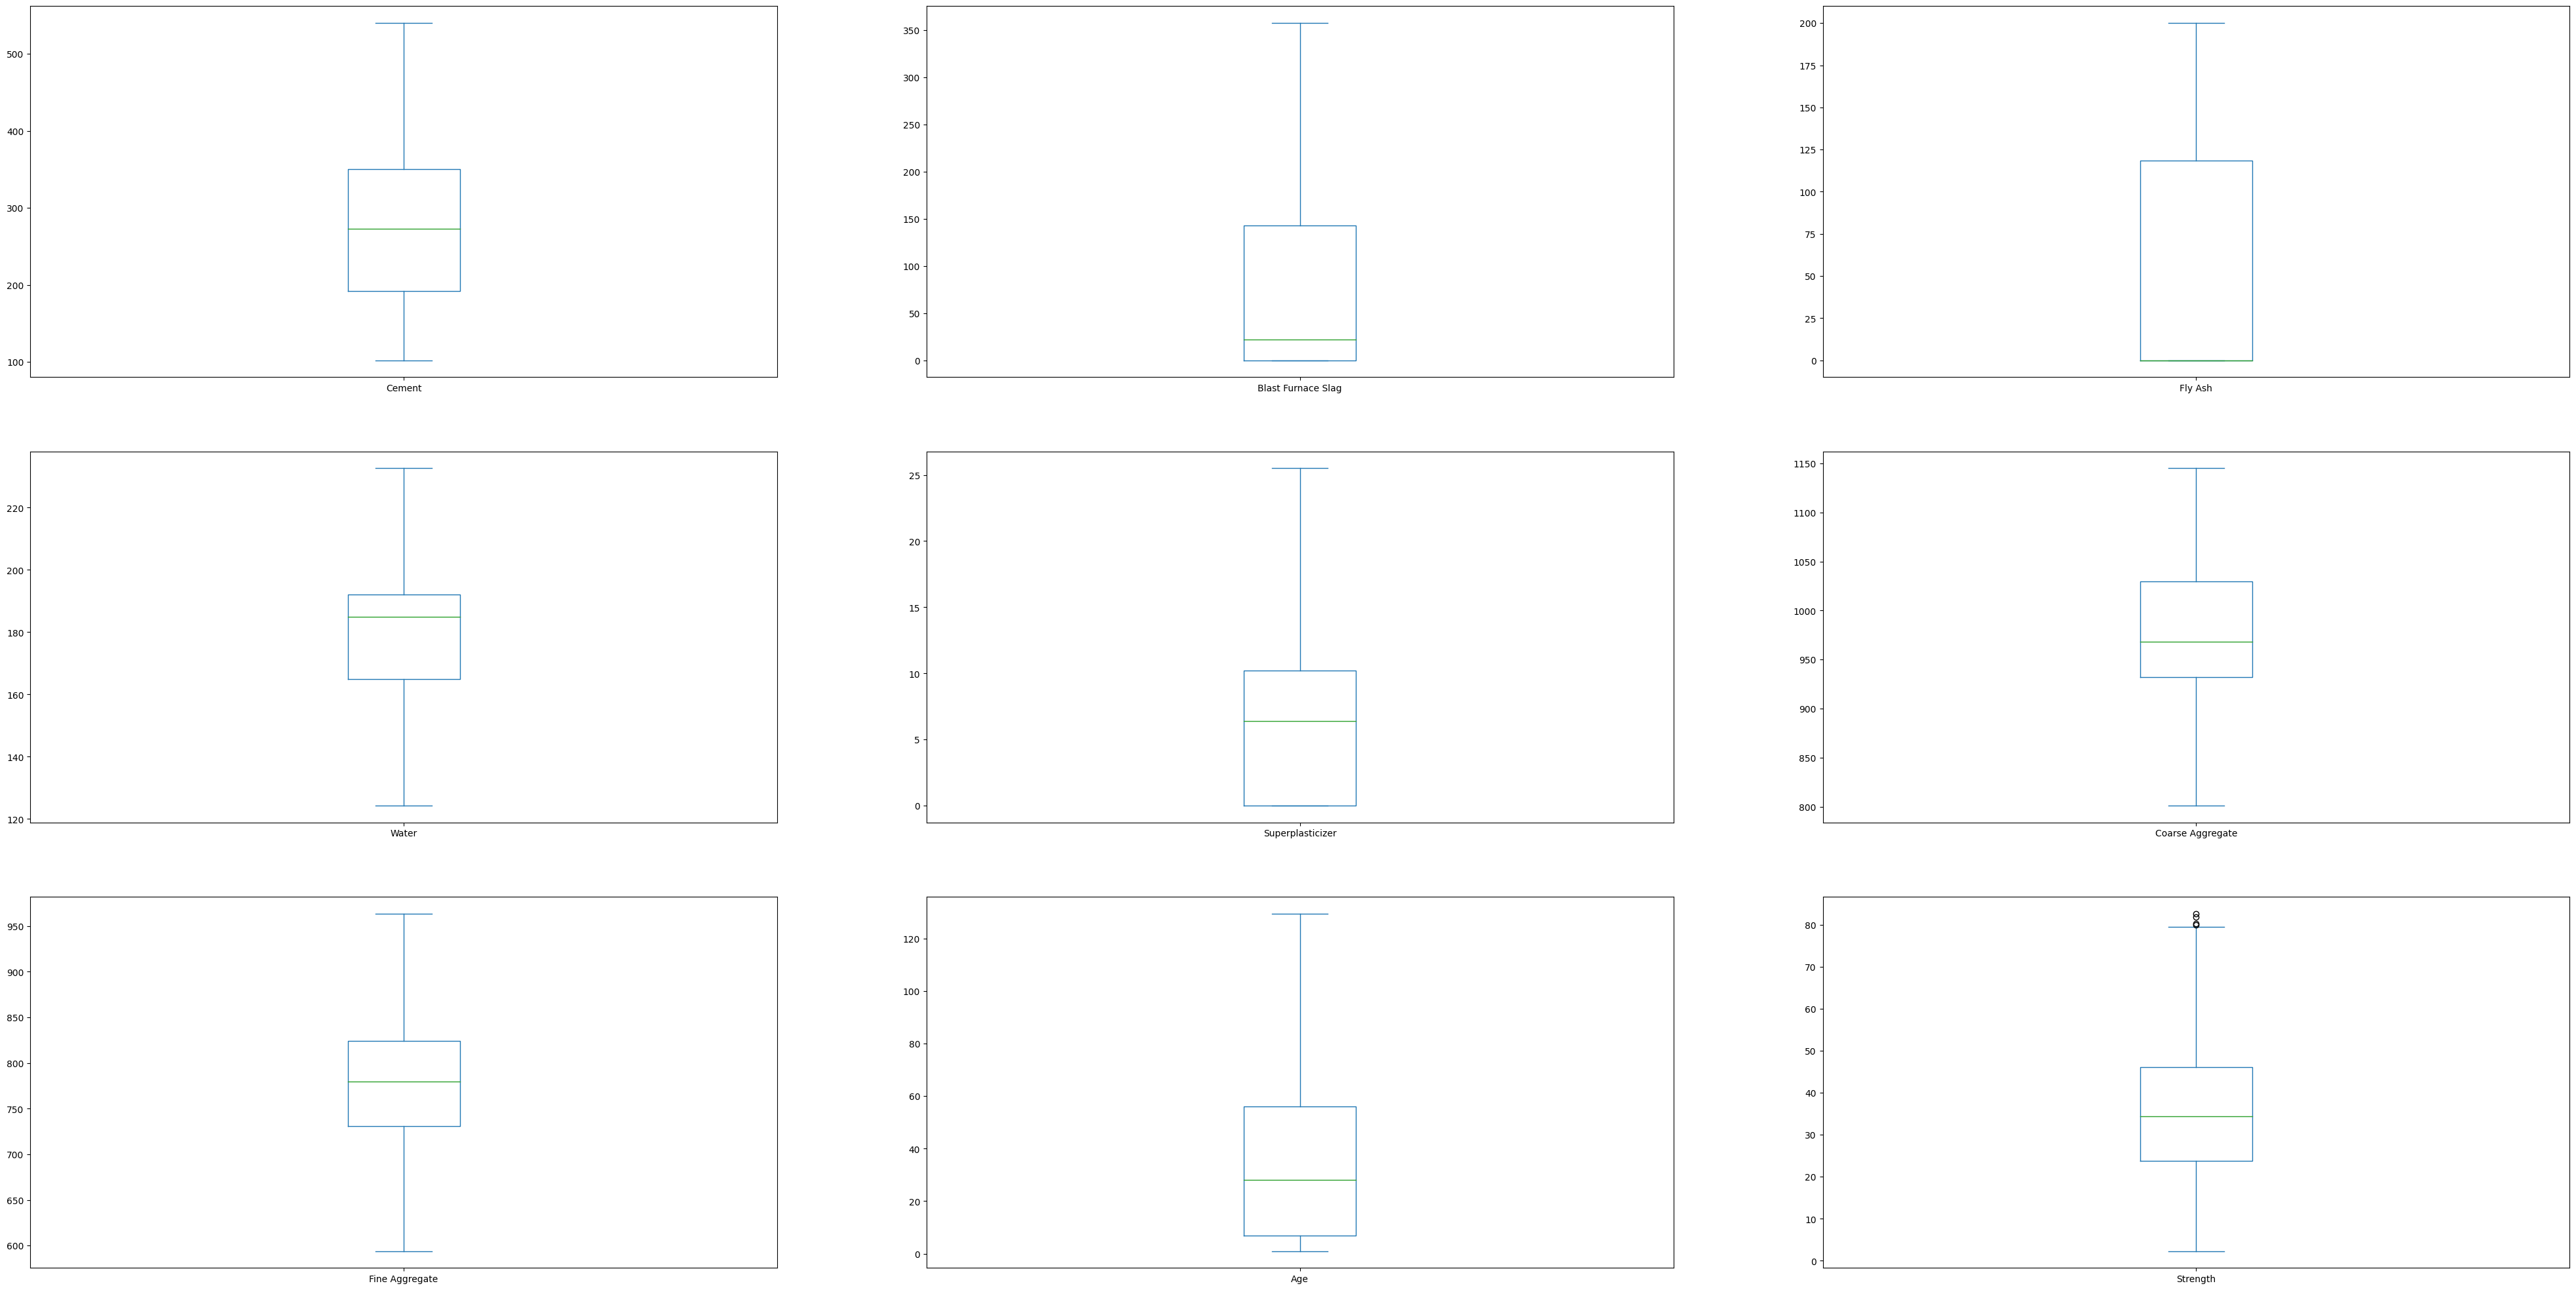

In [27]:
df2.plot(kind = "box",subplots = True,layout = (3,3),figsize=(50,25)) #Boxplot to check the outliers
plt.show()

Feature Engineering

In [29]:
X = df2.drop(['Strength'],axis=1)
y = df2.Strength

X.shape, y.shape

((1030, 8), (1030,))

In [30]:
# create X and Y datasets for training
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=42, test_size = 0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((824, 8), (206, 8), (824,), (206,))

In [32]:
from sklearn.linear_model import LinearRegression
lm=LinearRegression()
lm.fit(X_train,y_train)
test_pred=lm.predict(X_test)
from sklearn.metrics import mean_squared_error
E = mean_squared_error(test_pred,y_test)**0.5
print("The RMSE of Linear Regression is :",E)

The RMSE of Linear Regression is : 8.091266095784606


In [33]:
from sklearn.tree import DecisionTreeRegressor
reg=DecisionTreeRegressor()
reg.fit(X_train,y_train)
test_pred=reg.predict(X_test)
from sklearn.metrics import mean_squared_error
E = mean_squared_error(test_pred,y_test)**0.5
print("The RMSE of DecisionTreeRegressor is :",E)

The RMSE of DecisionTreeRegressor is : 6.617426711827473


In [35]:
from sklearn.neighbors import KNeighborsRegressor
reg=KNeighborsRegressor()
reg.fit(X_train,y_train)
test_pred=reg.predict(X_test)
from sklearn.metrics import mean_squared_error
E = mean_squared_error(test_pred,y_test)**0.5
print("The RMSE of KNeighborsRegressor is :",E)

The RMSE of KNeighborsRegressor is : 8.29385140370842


In [36]:
from catboost import CatBoostRegressor
reg=CatBoostRegressor(logging_level ='Silent',iterations=200)
reg.fit(X_train,y_train)
test_pred=reg.predict(X_test)
from sklearn.metrics import mean_squared_error
E = mean_squared_error(test_pred,y_test)**0.5
print("The RMSE of CatBoostRegressor is :",E)

The RMSE of CatBoostRegressor is : 4.240012864300756


In [41]:
from sklearn.preprocessing import MinMaxScaler

cols = X_train.columns
scaler = MinMaxScaler()
X_train_RF = scaler.fit_transform(X_train)
X_test_RF = scaler.transform(X_test)

X_train_RF = pd.DataFrame(X_train_RF,columns=cols)
X_test_RF = pd.DataFrame(X_test_RF,columns=cols)

In [42]:
X_train_RF.shape, X_test_RF.shape

((824, 8), (206, 8))

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
parameters = {
    'n_estimators': [100, 150, 200, 250, 300,500,1000],
    'max_depth': [10, 20, None],
    'bootstrap':[True],
    'min_samples_leaf': [1,2,4],
    'min_samples_split': [2,5,10]
}

rf_cv = RandomForestRegressor(random_state=42)

clf = GridSearchCV(rf_cv, parameters,verbose=10,n_jobs=6,cv=3)
clf.fit(X_train_RF, y_train)
print("Best params: ", clf.best_params_)

Fitting 3 folds for each of 189 candidates, totalling 567 fits
Best params:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


In [45]:
y_pred_RF_cv = clf.predict(X_test_RF)
print(y_pred_RF_cv)

[50.02025869 40.28374714 71.504796   34.69123167 11.41306    44.72539
 24.36597    48.37822    36.53842    43.38878867 41.1696     15.37946
 38.63031167 34.80131    24.51698    22.23179    36.92745    17.6952
 38.79152    31.76027    36.1739375  36.61125933 45.85322    11.55011
 33.39769    38.63754333 11.36929    44.2324     53.53614    15.23305
 60.3958025  34.00043667 42.30425    48.52119    17.36789    39.9715925
 35.75624    44.48149771  9.54532    51.17044    16.83005     5.07703
 41.67722719 48.89963025 12.94494    65.29294    52.99900265 34.19946436
 26.2355625   8.16385    55.45218    42.8579789  26.55971    17.66478
 44.966517   34.35199833 27.49403    12.2317     35.72602    19.93822
 44.42064    14.82511    35.952357   51.51397333 31.51086    25.094308
 34.15794    13.49912    30.12801917 24.15348    12.38031    29.018042
  9.29394    41.2219     26.56807    11.41209    50.3572985  50.48597
 57.521365    9.67159    38.34774467 45.518      38.18014462 39.77851
 40.81576055 3

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mae = mean_absolute_error(y_test,y_pred_RF_cv)
rmse = sqrt(mean_squared_error(y_test,y_pred_RF_cv))

print("Mean Absolute Error: {0}\nRoot Mean Square Error: {1}".format(round(mae,3),round(rmse,3)))

Mean Absolute Error: 3.858
Root Mean Square Error: 5.565


In [37]:
def get_dataset(x_train,y_train,N=5) :
    merge = pd.concat([x_train,y_train],axis=1)
    merge = merge.sample(frac=1, random_state=1).reset_index(drop=True)
    y_train = merge.iloc[:,(merge.shape[1]-1):(merge.shape[1])]
    x_train = merge.iloc[:,0:(merge.shape[1]-1)]
    
    z = int(len(x_train)/N)
    start = [0]
    stop = []
    for i in range(1,N):
        start.append(z*i)
        stop.append(z*i)
    stop.append(len(x_train))
    
    c = list()
    train_data = list()
    test_data = list()
    y_data = list()
    for i in range(0,N):
        c=list(range(start[i],stop[i]))
        train_data.append(x_train.iloc[[k for k in range(0,len(x_train)) if k not in c],:])
        y_data.append(y_train.iloc[[k for k in range(0,len(y_train)) if k not in c],:])
        test_data.append(x_train.iloc[c,:])
        
    return(train_data,y_data,test_data,y_train)

datasets = get_dataset(X_train,y_train,20)

train_data = datasets[0]
y_data = datasets[1]
test_data = datasets[2]
final_y =  datasets[3]

In [48]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, Pool

models = [LinearRegression(),
          DecisionTreeRegressor(),
          KNeighborsRegressor(),
          CatBoostRegressor(logging_level ='Silent'),
          RandomForestRegressor()
          ]
code = ['lin_reg','dtree_reg','Knn_reg','cat_reg','rf_reg']

In [49]:
def stack(x_train, y_train , x_test , models,code):
    
    def flatten_list(_2d_list):
        flat_list = []
        for element in _2d_list:
            if type(element) is list:
                for item in element:
                    flat_list.append(item)
            else:
                flat_list.append(element)
        return flat_list

    result = list()
    for i in list(range(len(models))):
        reg = models[i]
        reg.fit(x_train,y_train)
        test_pred = flatten_list(reg.predict(x_test).tolist())
        result.append(test_pred)

    result_df = pd.DataFrame()    
    for i in list(range(len(code))):
        result_df[code[i]] = result[i]
    return result_df

In [50]:
final_df = pd.DataFrame(columns = code)
for i in range(0,len(train_data)):
    current_df = stack(train_data[i],y_data[i],test_data[i],models,code)
    final_df = pd.concat([final_df,current_df])
    
final_test = stack(X_train,y_train,X_test,models,code)

final_df.head()

C:\Users\shara\AppData\Local\Temp\ipykernel_27060\3661647428.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(x_train,y_train)
C:\Users\shara\AppData\Local\Temp\ipykernel_27060\3661647428.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(x_train,y_train)
C:\Users\shara\AppData\Local\Temp\ipykernel_27060\3661647428.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(x_train,y_train)
C:\Users\shara\AppData\Local\Temp\ipykernel_27060\3661647428.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(x_train,y_train)


,lin_reg,dtree_reg,Knn_reg,cat_reg,rf_reg
0,17.541746,17.44,16.786,16.997438,14.7782
1,32.253942,23.52,35.052,24.225051,22.8887
2,23.600156,20.92,24.208,26.307572,23.3699
3,44.370764,40.15,41.606,43.011681,41.2054
4,19.682703,17.44,31.094,19.891466,16.6892


In [52]:
final_test.head()

,lin_reg,dtree_reg,Knn_reg,cat_reg,rf_reg
0,46.162543,50.215,49.520,51.108205,50.156775
1,48.385717,39.400,44.140,44.100873,42.063300
2,62.617059,71.300,64.338,73.650448,71.188900
3,47.369159,35.300,39.120,33.234836,34.132600
4,16.396390,10.540,12.214,11.387197,11.090000


In [55]:
reg2 = LinearRegression() 
reg2.fit(final_df,final_y)
test_pred = reg2.predict(final_test)
mean_squared_error(test_pred,y_test)**0.5

4.053118224436221

Blending??

In [56]:
def stackblend_reg(x_train,y_train,x_test,models,code,N=20,final_layer=LinearRegression()):
    
    def get_dataset(x_train,y_train,N=5) :
        merge = pd.concat([x_train,y_train],axis=1)
        merge = merge.sample(frac=1, random_state=1).reset_index(drop=True)
        y_train = merge.iloc[:,(merge.shape[1]-1):(merge.shape[1])]
        x_train = merge.iloc[:,0:(merge.shape[1]-1)]

        z = int(len(x_train)/N)
        start = [0]
        stop = []
        for i in range(1,N):
            start.append(z*i)
            stop.append(z*i)
        stop.append(len(x_train))

        c = list()
        train_data = list()
        test_data = list()
        y_data = list()
        for i in range(0,N):
            c=list(range(start[i],stop[i]))
            train_data.append(x_train.iloc[[k for k in range(0,len(x_train)) if k not in c],:])
            y_data.append(y_train.iloc[[k for k in range(0,len(y_train)) if k not in c],:])
            test_data.append(x_train.iloc[c,:])

        return(train_data,y_data,test_data,y_train)
    
    datasets = get_dataset(x_train,y_train,N)
    train_data = datasets[0]
    y_data = datasets[1]
    test_data = datasets[2]
    final_y =  datasets[3]
    
    def stack(x_train, y_train , x_test , models=models,code=code):
    
        def flatten_list(_2d_list):
            flat_list = []
            for element in _2d_list:
                if type(element) is list:
                    for item in element:
                        flat_list.append(item)
                else:
                    flat_list.append(element)
            return flat_list

        result = list()
        for i in list(range(len(models))):
            reg = models[i]
            reg.fit(x_train,y_train)
            test_pred = flatten_list(reg.predict(x_test).tolist())
            result.append(test_pred)

        result_df = pd.DataFrame()    
        for i in list(range(len(code))):
            result_df[code[i]] = result[i]
        return result_df
    final_df = pd.DataFrame(columns = code)
    
    for i in range(0,len(train_data)):
        current_df = stack(train_data[i],y_data[i],test_data[i],models,code)
        final_df = pd.concat([final_df,current_df])
        
    final_test = stack(x_train,y_train,x_test,models,code)
    
    reg2 = final_layer
    reg2.fit(final_df,final_y)
    test_pred = reg2.predict(final_test)
    
    return test_pred

In [62]:
stack_pred = stackblend_reg(X_train,y_train,X_test,
                            models = [LinearRegression(),
                                      DecisionTreeRegressor(),
                                      KNeighborsRegressor(),
                                      CatBoostRegressor(logging_level ='Silent')],
                            code = ['lin_reg','dtree_reg','Knn_reg','cat_reg'],N=5,
                            final_layer=LinearRegression())
mean_squared_error(stack_pred,y_test)**0.5

4.1791545082622505